# Generational changes in religious attitudes

Allen Downey

[MIT License](https://en.wikipedia.org/wiki/MIT_License)

In [1]:
from __future__ import print_function, division

%matplotlib inline

import pandas as pd
import numpy as np

import thinkstats2
import thinkplot
import utils

import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style='whitegrid', font_scale=1.5)

from statsmodels.discrete.discrete_model import MNLogit

Reading data from the [General Social Survey](https://gssdataexplorer.norc.org/projects/29853)

In [2]:
# !wget https://gssdataexplorer.norc.org/extracts/21438/download

In [3]:
gss = utils.ReadGss('gss_religion_data')
print(gss.shape)
gss.head()

(62466, 11)


,year,conclerg,bible,cohort,age,wtssall,ballot,relig,educ,id_,god
0,1972,0,0,1949,23,0.4446,0,3,16,1,0
1,1972,0,0,1902,70,0.8893,0,2,10,2,0
2,1972,0,0,1924,48,0.8893,0,1,12,3,0
3,1972,0,0,1945,27,0.8893,0,5,17,4,0
4,1972,0,0,1911,61,0.8893,0,1,12,5,0


Cleaning variables

In [4]:
# TODO: find out what code 4 is

gss.bible.replace([4, 8, 9, 0], np.nan, inplace=True)

In [5]:
utils.values(gss, 'bible')

1.0    11185
2.0    15926
3.0     5929
Name: bible, dtype: int64

In [6]:
gss.conclerg.replace([8, 9, 0], np.nan, inplace=True)

In [7]:
utils.values(gss, 'conclerg')

1.0    11366
2.0    20886
3.0     8660
Name: conclerg, dtype: int64

In [8]:
gss.god.replace([8, 9, 0], np.nan, inplace=True)
sum(gss.god.isnull())

40129

In [9]:
utils.values(gss, 'god')

1.0      673
2.0     1110
3.0     2286
4.0      900
5.0     3662
6.0    13706
Name: god, dtype: int64

In [10]:
gss.age.replace([98, 99], np.nan, inplace=True)
sum(gss.age.isnull())

221

In [11]:
gss.cohort.replace([9999], np.nan, inplace=True)
sum(gss.cohort.isnull())

221

In [12]:
gss.relig.replace([98, 99], np.nan, inplace=True)
sum(gss.relig.isnull())

269

In [13]:
gss.dropna(subset=['age', 'cohort', 'relig'], inplace=True)
gss.shape

(61995, 11)

We drop 471 records due to missing data.

In [14]:
62466 - 61995

471

Here's the distribution of ages.

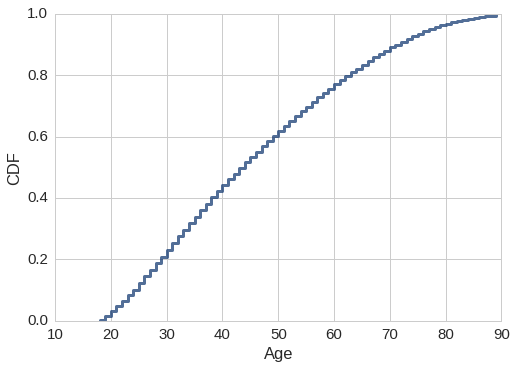

In [15]:
thinkplot.Cdf(thinkstats2.Cdf(gss.age))
thinkplot.Config(xlabel='Age', ylabel='CDF')

Group people into 5-year age groups.

In [16]:
gss['age_group'] = utils.RoundIntoBins(gss, 'age', 5) + 2.5

Here's the distribution of birth year.

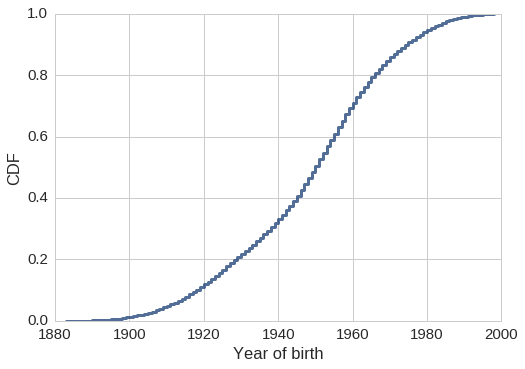

In [17]:
thinkplot.Cdf(thinkstats2.Cdf(gss.cohort))
thinkplot.Config(xlabel='Year of birth', ylabel='CDF')

Group people into 5- and 10-year bins by birth year.

In [18]:
gss['cohort5'] = utils.RoundIntoBins(gss, 'cohort', 5, low=4) + 2.5

In [19]:
grouped_cohort = gss.groupby(['cohort5'])
counts = grouped_cohort.relig.count()
counts

cohort5
1881.5       2
1886.5      37
1891.5     140
1896.5     365
1901.5     726
1906.5    1113
1911.5    1648
1916.5    2281
1921.5    2798
1926.5    3131
1931.5    3074
1936.5    3632
1941.5    4343
1946.5    5616
1951.5    6349
1956.5    6465
1961.5    5556
1966.5    4413
1971.5    3483
1976.5    2631
1981.5    2044
1986.5    1280
1991.5     658
1996.5     210
Name: relig, dtype: int64

In [20]:
gss['cohort10'] = utils.RoundIntoBins(gss, 'cohort', 10)

Here's the distribution of religion codes.

In [21]:
utils.values(gss, 'relig')

1.0     35856
2.0     15136
3.0      1233
4.0      7231
5.0      1064
6.0       177
7.0        88
8.0        38
9.0       135
10.0      112
11.0      760
12.0       30
13.0      135
Name: relig, dtype: int64

In [22]:
utils.values(gss, 'year')

1972    1603
1973    1496
1974    1477
1975    1483
1976    1491
1977    1516
1978    1522
1980    1456
1982    1837
1983    1588
1984    1456
1985    1522
1986    1460
1987    1802
1988    1476
1989    1530
1990    1367
1991    1513
1993    1592
1994    2976
1996    2894
1998    2792
2000    2805
2002    2735
2004    2792
2006    4468
2008    2004
2010    2028
2012    1962
2014    2513
2016    2839
Name: year, dtype: int64

In [23]:
sum(gss.relig.isnull())

0

In [24]:

def create_relig_vars(df):
    """Creates columns for religious categories.
    
    df: DataFrame
    """
    # lumping "Orthodox-Christian" and "Christian" with Protestant
    df['prot'] = (df.relig.isin([1,10,11]))
    df['cath'] = (df.relig==2)
    df['none'] = (df.relig==4)
    df['other'] = (df.relig.isin([3,5,6,7,8,9,12,13]))
    
    df['relig4'] = df.relig.copy()
    df.relig4.replace([10, 11], 1, inplace=True)
    df.relig4.replace([5,6,7,8,9,12,13], 3, inplace=True)

    varnames = ['prot', 'cath', 'none', 'other']
    df.loc[df.relig.isnull(), varnames + ['relig4']] = np.nan
    
create_relig_vars(gss)

In [25]:
utils.values(gss, 'relig4')

1.0    36728
2.0    15136
3.0     2900
4.0     7231
Name: relig4, dtype: int64

In [26]:
sum(gss.god.isnull())

39773

In [27]:
def create_belief_vars(df):
    """Creates columns for belief categories.
    
    df: DataFrame
    """
    df['nobelief'] = (df.god.isin([1, 2]))
    df['belief'] = (df.god.isin([3, 4, 5]))
    df['strongbelief'] = (df.god.isin([6]))
    
    df['belief3'] = df.god.copy()
    df.belief3.replace([1, 2], 1, inplace=True)
    df.belief3.replace([3, 4, 5], 2, inplace=True)
    df.belief3.replace([6], 3, inplace=True)

    varnames = ['strongbelief', 'belief', 'nobelief', 'belief3']
    df.loc[df.god.isnull(), varnames] = np.nan
    
create_belief_vars(gss)

In [28]:
utils.values(gss, 'belief3')

1.0     1778
2.0     6819
3.0    13625
Name: belief3, dtype: int64

In [29]:
sum(gss.conclerg.isnull())

21354

In [30]:
def create_conf_vars(df):
    """Creates columns for confidence in religion categories.
    
    df: DataFrame
    """
    df['confident'] = (df.conclerg == 1)
    df['someconf'] = (df.conclerg == 2)
    df['noconf'] = (df.conclerg == 3)

    varnames = ['confident', 'someconf', 'noconf']
    df.loc[df.conclerg.isnull(), varnames] = np.nan
    
create_conf_vars(gss)

In [31]:
utils.values(gss, 'conclerg')

1.0    11308
2.0    20740
3.0     8593
Name: conclerg, dtype: int64

In [32]:
sum(gss.bible.isnull())

29138

In [33]:
def create_bible_vars(df):
    """Creates columns for bible interpretation categories.
    
    df: DataFrame
    """
    df['word'] = (df.bible == 1)
    df['inspired'] = (df.bible == 2)
    df['legends'] = (df.bible == 3)

    varnames = ['word', 'inspired', 'legends']
    df.loc[df.bible.isnull(), varnames] = np.nan
    
create_bible_vars(gss)

In [34]:
utils.values(gss, 'bible')

1.0    11123
2.0    15843
3.0     5891
Name: bible, dtype: int64

Resampling (bootstrapping to be more specific) to account for sampling weights.

In [35]:
sample = utils.ResampleByYear(gss)
sample.head()

,year,conclerg,bible,cohort,age,wtssall,ballot,relig,educ,id_,...,nobelief,belief,strongbelief,belief3,confident,someconf,noconf,word,inspired,legends
0,1972,NaN,NaN,1922.0,50.0,0.4446,0,4.0,18,165,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1972,NaN,NaN,1924.0,48.0,0.8893,0,1.0,11,999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1972,NaN,NaN,1916.0,56.0,0.8893,0,1.0,12,908,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1972,NaN,NaN,1942.0,30.0,0.8893,0,1.0,16,1056,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1972,NaN,NaN,1915.0,57.0,0.8893,0,1.0,7,1332,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
def center_factors(df):
    """Center factors around their means.
    
    Add centered factors for the model.
    
    df: DataFrame
    """
    df['ones'] = np.ones_like(df.cohort)
    df['c'] = df.cohort - 1966
    df['c2'] = df.c**2
    df['a'] = df.age - 47
    df['a2'] = df.a**2
    df['ac'] = df.a * df.c

In [37]:
center_factors(sample)

In [38]:
formula = 'prot ~ c + c2 + a + a2'
results = smf.logit(formula, data=sample).fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.664112
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   prot   No. Observations:                61995
Model:                          Logit   Df Residuals:                    61990
Method:                           MLE   Df Model:                            4
Date:                Thu, 01 Jun 2017   Pseudo R-squ.:                 0.02233
Time:                        09:44:06   Log-Likelihood:                -41172.
converged:                       True   LL-Null:                       -42112.
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0599      0.017      3.626      0.000       0.028       0.092
c             -0.0214      0.001    -24.201      0.000      -0.023      -0.020
c2         -8.253e-05   1.84e-05     -4.490      0.000      -0.000   -4.65e-05
a             -0.0017      0.001     -2.163      0.031      -0.003      -0.000
a2         -5.408e-05   3.13e-05     -1.728      0.084      -0.000    7.26e-06
==============================================================================
"""

In [39]:
formula = 'cath ~ c + c2 + a + a2'
results = smf.logit(formula, data=sample).fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.567303
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   cath   No. Observations:                61995
Model:                          Logit   Df Residuals:                    61990
Method:                           MLE   Df Model:                            4
Date:                Thu, 01 Jun 2017   Pseudo R-squ.:                0.001364
Time:                        09:44:06   Log-Likelihood:                -35170.
converged:                       True   LL-Null:                       -35218.
                                        LLR p-value:                 6.752e-20
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.0922      0.019    -58.451      0.000      -1.129      -1.056
c             -0.0039      0.001     -3.944      0.000      -0.006      -0.002
c2            -0.0001   2.04e-05     -6.227      0.000      -0.000    -8.7e-05
a             -0.0032      0.001     -3.630      0.000      -0.005      -0.001
a2             0.0001   3.45e-05      3.646      0.000    5.82e-05       0.000
==============================================================================
"""

In [40]:
formula = 'none ~ c + c2 + a + a2'
results = smf.logit(formula, data=sample).fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.336244
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   none   No. Observations:                61995
Model:                          Logit   Df Residuals:                    61990
Method:                           MLE   Df Model:                            4
Date:                Thu, 01 Jun 2017   Pseudo R-squ.:                 0.06303
Time:                        09:44:06   Log-Likelihood:                -20845.
converged:                       True   LL-Null:                       -22248.
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.5455      0.024    -64.417      0.000      -1.593      -1.499
c              0.0395      0.001     32.948      0.000       0.037       0.042
c2         -1.242e-05   3.31e-05     -0.375      0.708   -7.73e-05    5.25e-05
a              0.0085      0.001      6.358      0.000       0.006       0.011
a2          4.536e-05   5.59e-05      0.811      0.417   -6.43e-05       0.000
==============================================================================
"""

In [41]:
formula = 'other ~ c + c2 + a + a2'
results = smf.logit(formula, data=sample).fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.184569
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  other   No. Observations:                61995
Model:                          Logit   Df Residuals:                    61990
Method:                           MLE   Df Model:                            4
Date:                Thu, 01 Jun 2017   Pseudo R-squ.:                0.005008
Time:                        09:44:06   Log-Likelihood:                -11442.
converged:                       True   LL-Null:                       -11500.
                                        LLR p-value:                 5.677e-24
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.8103      0.037    -75.849      0.000      -2.883      -2.738
c              0.0165      0.002      8.514      0.000       0.013       0.020
c2             0.0001    4.2e-05      2.540      0.011    2.43e-05       0.000
a              0.0061      0.002      3.223      0.001       0.002       0.010
a2            -0.0001   7.56e-05     -1.572      0.116      -0.000    2.94e-05
==============================================================================
"""

## Generational replacement

Choose colors

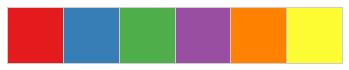

In [42]:
RED, BLUE, GREEN, PURPLE, ORANGE, YELLOW = sns.color_palette('Set1')
sns.palplot(sns.color_palette('Set1'))

In [43]:
def make_series_seq(grouped, varnames):
    """Compute the percentage in each category.
    
    grouped: GroupBy object with one-hots for each category
    varnames: list of string column names
    
    returns: list of Series
    """
    return [grouped[var].mean() * 100 for var in varnames]

def plot_series_seq(series_seq, colors, labels):
    """Plots Series objects.
    
    series_seq: list of Series
    colors: list of string colors
    labels: list of string labels
    """
    for series, color, label in zip(series_seq, colors, labels):
        thinkplot.plot(series, color=color, label=label)

In [44]:
def plot_relig(grouped):
    """Plot one line for each religious group.
    
    grouped: GroupBy object with one-hots for each religious group
    """
    varnames = ['prot', 'cath', 'none', 'other']
    colors = [ORANGE, GREEN, RED, BLUE]
    labels = ['Protestant', 'Catholic', 'None', 'Other']
    series_seq = make_series_seq(grouped, varnames)
    plot_series_seq(series_seq, colors, labels)

Plot the percentage in each religious group as a function of survey year.

In [45]:
grouped_year = sample.groupby(['year'])
grouped_year.none.count()

year
1972    1603
1973    1496
1974    1477
1975    1483
1976    1491
1977    1516
1978    1522
1980    1456
1982    1837
1983    1588
1984    1456
1985    1522
1986    1460
1987    1802
1988    1476
1989    1530
1990    1367
1991    1513
1993    1592
1994    2976
1996    2894
1998    2792
2000    2805
2002    2735
2004    2792
2006    4468
2008    2004
2010    2028
2012    1962
2014    2513
2016    2839
Name: none, dtype: int64

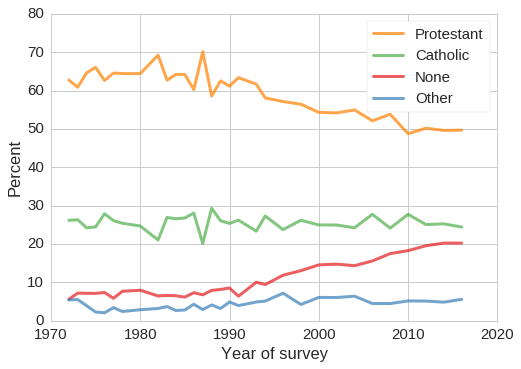

In [46]:
plot_relig(grouped_year)
thinkplot.config(xlabel='Year of survey', ylabel='Percent')

In [47]:
grouped_age = sample.groupby(['age_group'])
grouped_age.none.count()

age_group
17.5    1482
22.5    6257
27.5    6686
32.5    6567
37.5    6100
42.5    5998
47.5    5808
52.5    5252
57.5    4545
62.5    3842
67.5    3248
72.5    2645
77.5    1783
82.5    1105
87.5     677
Name: none, dtype: int64

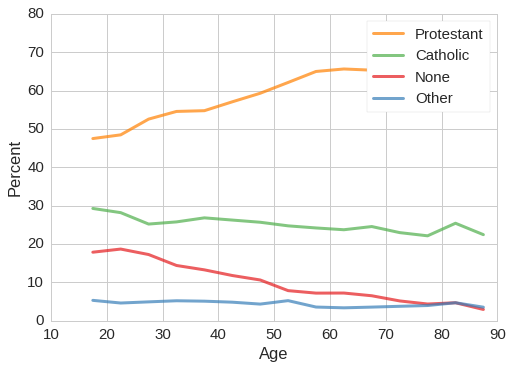

In [48]:
plot_relig(grouped_age)
thinkplot.config(xlabel='Age', ylabel='Percent')

Plot the percentage in each religious group as a function of birth cohort.

In [49]:
grouped_cohort = sample.groupby(['cohort5'])
counts = grouped_cohort.relig.count()
counts

cohort5
1881.5       5
1886.5      27
1891.5     101
1896.5     293
1901.5     634
1906.5     938
1911.5    1333
1916.5    2126
1921.5    2580
1926.5    3053
1931.5    3097
1936.5    3682
1941.5    4322
1946.5    5420
1951.5    6255
1956.5    6597
1961.5    5670
1966.5    4568
1971.5    3656
1976.5    2815
1981.5    2262
1986.5    1461
1991.5     808
1996.5     292
Name: relig, dtype: int64

In [50]:
since_1900 = sample.loc[sample.cohort >= 1900]
grouped_cohort = since_1900.groupby(['cohort5'])

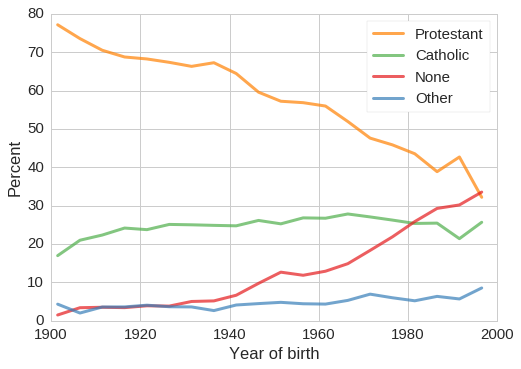

In [51]:
plot_relig(grouped_cohort)
thinkplot.config(xlabel='Year of birth', ylabel='Percent')

Before running models, center the factors we're planning to use.

In [52]:
def center_factors(df):
    """Center factors around their means.
    
    Add centered factors for the model.
    
    df: DataFrame
    """
    df['ones'] = np.ones_like(df.cohort)
    df['c'] = df.cohort - 1966
    df['c2'] = df.c**2
    df['a'] = df.age - 47
    df['a2'] = df.a**2
    df['ac'] = df.a * df.c

In [53]:
center_factors(sample)
sample.head()

,year,conclerg,bible,cohort,age,wtssall,ballot,relig,educ,id_,...,noconf,word,inspired,legends,ones,c,c2,a,a2,ac
0,1972,NaN,NaN,1922.0,50.0,0.4446,0,4.0,18,165,...,NaN,NaN,NaN,NaN,1.0,-44.0,1936.0,3.0,9.0,-132.0
1,1972,NaN,NaN,1924.0,48.0,0.8893,0,1.0,11,999,...,NaN,NaN,NaN,NaN,1.0,-42.0,1764.0,1.0,1.0,-42.0
2,1972,NaN,NaN,1916.0,56.0,0.8893,0,1.0,12,908,...,NaN,NaN,NaN,NaN,1.0,-50.0,2500.0,9.0,81.0,-450.0
3,1972,NaN,NaN,1942.0,30.0,0.8893,0,1.0,16,1056,...,NaN,NaN,NaN,NaN,1.0,-24.0,576.0,-17.0,289.0,408.0
4,1972,NaN,NaN,1915.0,57.0,0.8893,0,1.0,7,1332,...,NaN,NaN,NaN,NaN,1.0,-51.0,2601.0,10.0,100.0,-510.0


## Religious affiliation

Run logistic regression to fit models to each religious group.

In [54]:
def make_model(df, var):
    """Fit a logistic regression model.
    
    df: DataFrame
    var: string name of dependent variable
    """
    formula = var + ' ~ c + c2 + a + a2 + ac'
    return smf.logit(formula, data=df).fit()

In [55]:
make_model(sample, 'prot').summary()

Optimization terminated successfully.
         Current function value: 0.663917
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   prot   No. Observations:                61995
Model:                          Logit   Df Residuals:                    61989
Method:                           MLE   Df Model:                            5
Date:                Thu, 01 Jun 2017   Pseudo R-squ.:                 0.02262
Time:                        09:44:08   Log-Likelihood:                -41160.
converged:                       True   LL-Null:                       -42112.
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0099      0.019      0.513      0.608      -0.028       0.048
c             -0.0308      0.002    -14.598      0.000      -0.035      -0.027
c2            -0.0003   5.32e-05     -6.171      0.000      -0.000      -0.000
a             -0.0120      0.002     -5.372      0.000      -0.016      -0.008
a2            -0.0003   6.67e-05     -5.165      0.000      -0.000      -0.000
ac            -0.0005      0.000     -4.925      0.000      -0.001      -0.000
==============================================================================
"""

In [56]:
make_model(sample, 'cath').summary()

Optimization terminated successfully.
         Current function value: 0.567275
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   cath   No. Observations:                61995
Model:                          Logit   Df Residuals:                    61989
Method:                           MLE   Df Model:                            5
Date:                Thu, 01 Jun 2017   Pseudo R-squ.:                0.001413
Time:                        09:44:08   Log-Likelihood:                -35168.
converged:                       True   LL-Null:                       -35218.
                                        LLR p-value:                 6.736e-20
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.0707      0.022    -48.819      0.000      -1.114      -1.028
c           8.412e-05      0.002      0.036      0.972      -0.005       0.005
c2         -2.386e-05   5.92e-05     -0.403      0.687      -0.000    9.22e-05
a              0.0012      0.002      0.476      0.634      -0.004       0.006
a2             0.0002   7.38e-05      3.345      0.001       0.000       0.000
ac             0.0002      0.000      1.854      0.064   -1.29e-05       0.000
==============================================================================
"""

In [57]:
make_model(sample, 'none').summary()

Optimization terminated successfully.
         Current function value: 0.336032
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   none   No. Observations:                61995
Model:                          Logit   Df Residuals:                    61989
Method:                           MLE   Df Model:                            5
Date:                Thu, 01 Jun 2017   Pseudo R-squ.:                 0.06363
Time:                        09:44:09   Log-Likelihood:                -20832.
converged:                       True   LL-Null:                       -22248.
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.4795      0.027    -54.871      0.000      -1.532      -1.427
c              0.0541      0.003     17.585      0.000       0.048       0.060
c2             0.0004   8.46e-05      4.607      0.000       0.000       0.001
a              0.0243      0.003      7.297      0.000       0.018       0.031
a2             0.0005      0.000      4.877      0.000       0.000       0.001
ac             0.0009      0.000      5.165      0.000       0.001       0.001
==============================================================================
"""

In [58]:
make_model(sample, 'other').summary()

Optimization terminated successfully.
         Current function value: 0.184507
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  other   No. Observations:                61995
Model:                          Logit   Df Residuals:                    61989
Method:                           MLE   Df Model:                            5
Date:                Thu, 01 Jun 2017   Pseudo R-squ.:                0.005345
Time:                        09:44:09   Log-Likelihood:                -11439.
converged:                       True   LL-Null:                       -11500.
                                        LLR p-value:                 7.495e-25
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.8705      0.044    -65.950      0.000      -2.956      -2.785
c              0.0043      0.005      0.899      0.369      -0.005       0.014
c2            -0.0002      0.000     -1.753      0.080      -0.000    2.59e-05
a             -0.0075      0.005     -1.418      0.156      -0.018       0.003
a2            -0.0005      0.000     -3.157      0.002      -0.001      -0.000
ac            -0.0007      0.000     -2.761      0.006      -0.001      -0.000
==============================================================================
"""

In [59]:
formula = 'relig4 ~ a + c'
model = smf.mnlogit(formula, data=sample).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 1.026346
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                 relig4   No. Observations:                61995
Model:                        MNLogit   Df Residuals:                    61986
Method:                           MLE   Df Model:                            6
Date:                Thu, 01 Jun 2017   Pseudo R-squ.:                 0.02613
Time:                        09:44:09   Log-Likelihood:                -63628.
converged:                       True   LL-Null:                       -65336.
                                        LLR p-value:                     0.000
==============================================================================
  relig4=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.6838      0.017    -39.648      0.000      -0.718      -0.650
a             -0.0016      0.001     -1.769      0.077      -0.003       0.000
c              0.0082      0.001     10.994      0.000       0.007       0.010
------------------------------------------------------------------------------
  relig4=3       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.1884      0.033    -66.578      0.000      -2.253      -2.124
a              0.0075      0.002      4.042      0.000       0.004       0.011
c              0.0211      0.002     13.654      0.000       0.018       0.024
------------------------------------------------------------------------------
  relig4=4       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.0539      0.022    -49.019      0.000      -1.096      -1.012
a              0.0082      0.001      6.273      0.000       0.006       0.011
c              0.0434      0.001     39.946      0.000       0.041       0.046
==============================================================================
"""

## Multinomial models

In [60]:
def make_multi_model(df, var, factors):
    """Fit a multinomial logistic regression model.
    
    df: DataFrame
    var: string name of dependent variable
    factors: list of string names for factors
    
    returns: MNLogit model
    """
    # TODO: investigate the missing=drop option
    nonull = df.dropna(subset=factors+[var])
    y = nonull[var].values
    X = nonull[factors].values
    return MNLogit(y, X).fit(disp=False, full_output=False)

In [61]:
def predict_multi_model(age, model, year, factors, index):
    """Make a single-year prediction.
    
    age: Series of ages to simulate
    model: MNLogit model
    year: year to make a prediction for
    factors: list of string names for factors
    index: list of strings, index of result Series
    
    returns: Series that maps index to percentage
    """
    # resample the ages
    n = len(age)
    age = np.random.choice(age, n, replace=True)
    
    # generate ages and cohort
    cohort = year - age
    df = pd.DataFrame(dict(cohort=cohort, age=age))
    center_factors(df)
    
    # compute probabilities in each category for each respondent
    X = df[factors].values
    pred = model.predict(X)
    
    # simplification:
    # assume that all respondents have the mean probability for
    # each category, and sample from the multinomial distribution
    means = pred.mean(axis=0)
    freqs = np.random.multinomial(n, means) / n
    
    # here's the version that doesn't use the simplification.
    # it's slower.
    
    # xs = np.arange(1, model.model.J+1)
    # func = lambda row: np.random.choice(xs, p=row)
    # choices = np.apply_along_axis(func, 1, pred)
    # _, counts = np.unique(choices, return_counts=True)
    # freqs = counts / n

    return pd.Series(freqs, index=index) * 100

In [62]:
train_year = 2016
train = sample[sample.year <= train_year]

In [63]:
factors = ['ones', 'a', 'c']
model = make_multi_model(train, 'relig4', factors)

In [64]:
age = sample.loc[sample.year==train_year, 'age']
index = ['prot', 'cath', 'other', 'none']

In [65]:
predict_multi_model(age, model, 1976, factors, index)

prot     67.840789
cath     24.374780
other     2.817894
none      4.966538
dtype: float64

In [66]:
predict_multi_model(age, model, 2016, factors, index)

prot     49.559704
cath     23.705530
other     5.917577
none     20.817189
dtype: float64

In [67]:
predict_multi_model(age, model, 2026, factors, index)

prot     43.818246
cath     23.036280
other     5.706235
none     27.439239
dtype: float64

In [68]:
predict_multi_model(age, model, 2036, factors, index)

prot     38.534695
cath     20.429729
other     6.939063
none     34.096513
dtype: float64

In [69]:
def make_multi_pred(df, var, varnames, train_year, years, factors, index):
    """Generate predictions from multinomial model.
    
    df: DataFrame of respondents
    var: dependent variable
    varnames: list of string variable names
    train_year: upper bound or (low, high) tuple for years of data
    years: sequence of years to generate predictions for
    factors: list of string factor names for the model
    index: index for the resulting DataFrame
    
    returns: DataFrame that maps from index to predicted values
    """
    try:
        low, high = train_year
    except TypeError:
        low = 0
        high = train_year
        
    train = df[(df.year >= low) & (df.year <= high)]
    age = df.loc[df.year==high, 'age']
    
    model = make_multi_model(train, var, factors)
    
    pred = pd.DataFrame(columns=varnames)
    for year in years:
        pred.loc[year] = predict_multi_model(age, model, year, factors, index)
    return pred

In [72]:
def plot_multi_pred(df, pred, varnames, colors, alpha=0.3):
    """Plots predictions from multinomial model.
    
    pred: DataFrame with one column per variable
    varnames: list of string variable names
    colors: list of string colors
    alpha: numerical transparency
    """
    series_seq = [pred[var] for var in varnames]
    for series, color in zip(series_seq, colors):
        thinkplot.plot(series, color=color, alpha=alpha)
    thinkplot.config(xlabel='Year of survey', loc='upper right')

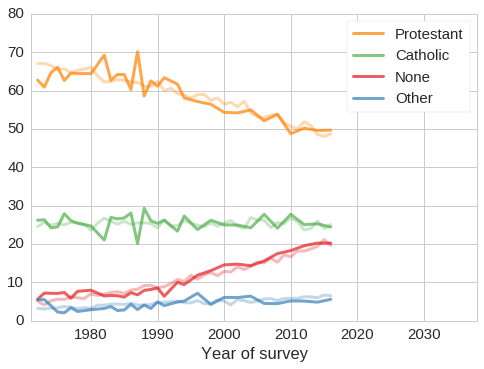

In [73]:
var = 'relig4'
varnames = ['prot', 'cath', 'none', 'other']
colors = [ORANGE, GREEN, RED, BLUE]
train_year = 2006
years = np.arange(1972, 2017)
factors = ['ones', 'a', 'c']
index = ['prot', 'cath', 'other', 'none']

pred = make_multi_pred(sample, var, varnames, train_year, years, factors, index)
plot_multi_pred(sample, pred, varnames, colors)
plot_relig(grouped_year)
thinkplot.config(xlim=[1971, 2038])

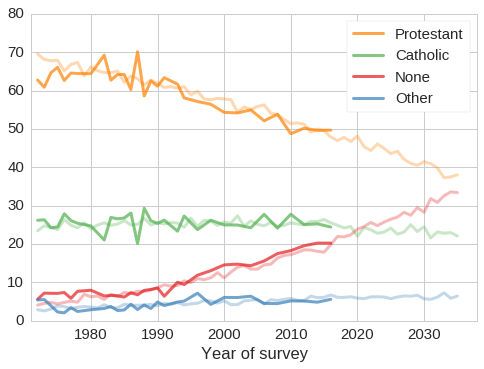

In [74]:
train_year = 2016
years = np.arange(1972, 2036)

pred = make_multi_pred(sample, var, varnames, train_year, years, factors, index)
plot_multi_pred(sample, pred, varnames, colors)
plot_relig(grouped_year)

thinkplot.config(xlim=[1971, 2038])

## Belief in God

I don''t believe in God.....................1 

I don''t know whether there is a God and I don''t believe there is any way to find out..................................2

I don''t believe in a personal God, but I do believe in a Higher Power of some kind........................3 

I find myself believing in God some of the time, but not at others........4 

While I have doubts, I feel that I do believe in God….............................5 

I know God really exists and I have no doubts about it...........................6

In [75]:
RED, PINK, _, _, LTBLUE, DKBLUE = sns.color_palette('RdBu', 6)
belief_colors = [BLUE, PURPLE, RED]

In [76]:
def plot_beliefs(grouped):
    """Plot belief categories.
    
    grouped: GroupBy object
    """
    varnames = ['strongbelief', 'belief', 'nobelief']
    colors = [BLUE, PURPLE, RED]
    labels = ['Strong belief', 'Belief', 'No belief']
    series_seq = make_series_seq(grouped, varnames)
    plot_series_seq(series_seq, colors, labels)

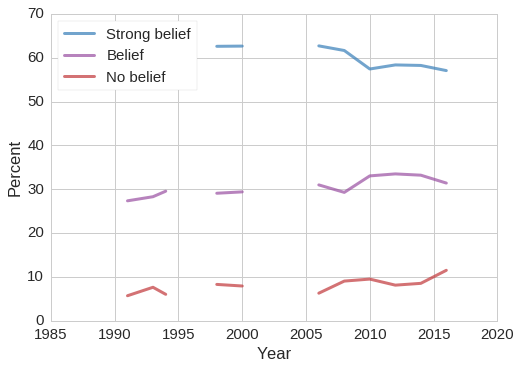

In [77]:
plot_beliefs(grouped_year)
thinkplot.config(xlabel='Year', ylabel='Percent', loc='upper left')

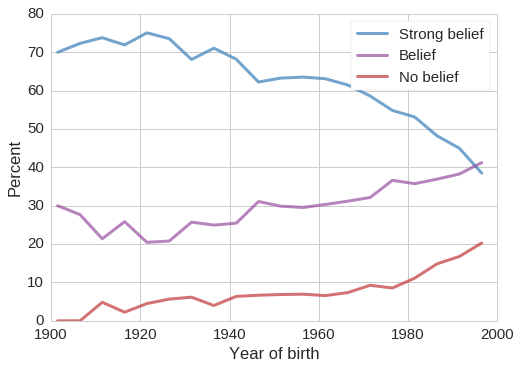

In [78]:
plot_beliefs(grouped_cohort)
thinkplot.config(xlabel='Year of birth', ylabel='Percent', loc='upper right')

In [79]:
make_model(sample, 'strongbelief').summary()

Optimization terminated successfully.
         Current function value: 0.658206
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           strongbelief   No. Observations:                22294
Model:                          Logit   Df Residuals:                    22288
Method:                           MLE   Df Model:                            5
Date:                Thu, 01 Jun 2017   Pseudo R-squ.:                 0.01580
Time:                        10:04:35   Log-Likelihood:                -14674.
converged:                       True   LL-Null:                       -14910.
                                        LLR p-value:                 1.271e-99
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3975      0.023     17.194      0.000       0.352       0.443
c             -0.0256      0.005     -5.487      0.000      -0.035      -0.016
c2            -0.0006      0.000     -2.572      0.010      -0.001      -0.000
a             -0.0075      0.005     -1.568      0.117      -0.017       0.002
a2            -0.0005      0.000     -2.146      0.032      -0.001   -4.26e-05
ac            -0.0009      0.000     -2.038      0.042      -0.002   -3.35e-05
==============================================================================
"""

In [80]:
make_model(sample, 'belief').summary()

Optimization terminated successfully.
         Current function value: 0.614099
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 belief   No. Observations:                22294
Model:                          Logit   Df Residuals:                    22288
Method:                           MLE   Df Model:                            5
Date:                Thu, 01 Jun 2017   Pseudo R-squ.:                0.006569
Time:                        10:04:35   Log-Likelihood:                -13691.
converged:                       True   LL-Null:                       -13781.
                                        LLR p-value:                 3.186e-37
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.7638      0.024    -31.399      0.000      -0.811      -0.716
c              0.0143      0.005      2.913      0.004       0.005       0.024
c2             0.0003      0.000      1.261      0.207      -0.000       0.001
a              0.0031      0.005      0.627      0.530      -0.007       0.013
a2             0.0003      0.000      1.236      0.216      -0.000       0.001
ac             0.0005      0.000      1.209      0.227      -0.000       0.001
==============================================================================
"""

In [81]:
make_model(sample, 'nobelief').summary()

Optimization terminated successfully.
         Current function value: 0.275949
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               nobelief   No. Observations:                22294
Model:                          Logit   Df Residuals:                    22288
Method:                           MLE   Df Model:                            5
Date:                Thu, 01 Jun 2017   Pseudo R-squ.:                 0.02066
Time:                        10:04:35   Log-Likelihood:                -6152.0
converged:                       True   LL-Null:                       -6281.8
                                        LLR p-value:                 4.993e-54
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.4200      0.041    -58.452      0.000      -2.501      -2.339
c              0.0360      0.008      4.390      0.000       0.020       0.052
c2             0.0008      0.000      1.960      0.050    1.27e-07       0.002
a              0.0134      0.008      1.584      0.113      -0.003       0.030
a2             0.0007      0.000      1.631      0.103      -0.000       0.002
ac             0.0011      0.001      1.445      0.148      -0.000       0.003
==============================================================================
"""

In [82]:
formula = 'belief3 ~ c + a'
model = smf.mnlogit(formula, data=sample).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.856784
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                belief3   No. Observations:                22294
Model:                        MNLogit   Df Residuals:                    22288
Method:                           MLE   Df Model:                            4
Date:                Thu, 01 Jun 2017   Pseudo R-squ.:                 0.01331
Time:                        10:04:35   Log-Likelihood:                -19101.
converged:                       True   LL-Null:                       -19359.
                                        LLR p-value:                3.044e-110
==============================================================================
 belief3=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2766      0.035     36.802      0.000       1.209       1.345
c             -0.0158      0.003     -5.193      0.000      -0.022      -0.010
a             -0.0045      0.003     -1.342      0.180      -0.011       0.002
------------------------------------------------------------------------------
 belief3=3       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.8834      0.033     57.067      0.000       1.819       1.948
c             -0.0275      0.003     -9.487      0.000      -0.033      -0.022
a             -0.0025      0.003     -0.777      0.437      -0.009       0.004
==============================================================================
"""

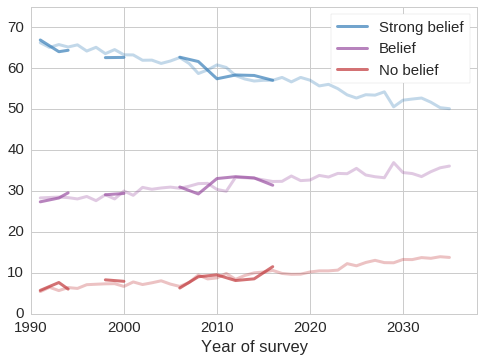

In [83]:
var = 'belief3'
varnames = ['strongbelief', 'belief', 'nobelief']
colors = [BLUE, PURPLE, RED]
train_year = 2016
years = np.arange(1991, 2036)
factors = ['ones', 'a', 'c']
index = ['nobelief', 'belief', 'strongbelief']

pred = make_multi_pred(sample, var, varnames, train_year, years, factors, index)
plot_multi_pred(sample, pred, varnames, colors)
plot_beliefs(grouped_year)

thinkplot.config(xlim=[1990, 2038], ylim=[0, 75])

In [84]:
make_multi_pred(sample, var, varnames, train_year, [1996, 2016, 2036], factors, index)

,strongbelief,belief,nobelief
1996,64.283198,29.094752,6.622050
2016,57.766819,32.335329,9.897851
2036,48.608665,36.069038,15.322297


## Confidence in people running organized religion

As far as the people running this institution [organized religion] are concerned, would you say you have a great deal of confidence, only some confidence, or hardly any confidence at all in them?

1. A great deal
2. Only some
3. Hardly any



In [85]:
def plot_conf(grouped):
    """Plot confidence in religion categories.
    
    grouped: GroupBy object
    """
    varnames = ['confident', 'someconf', 'noconf']
    colors = [BLUE, PURPLE, RED]
    labels = ['Great deal', 'Only some', 'Hardly any']
    series_seq = make_series_seq(grouped, varnames)
    plot_series_seq(series_seq, colors, labels)

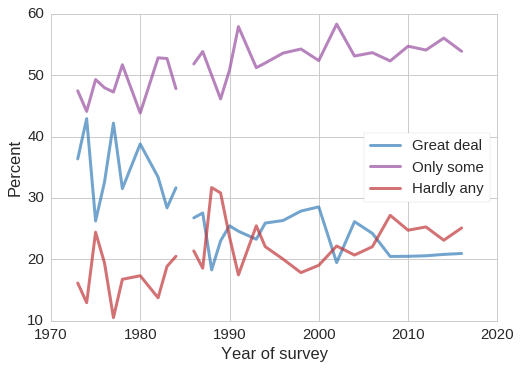

In [86]:
plot_conf(grouped_year)
thinkplot.config(xlabel='Year of survey', ylabel='Percent', loc='center right')

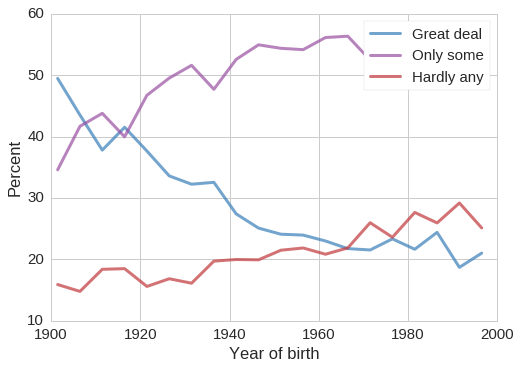

In [87]:
plot_conf(grouped_cohort)
thinkplot.config(xlabel='Year of birth', ylabel='Percent', loc='upper right')

In [88]:
make_model(sample, 'confident').summary()

Optimization terminated successfully.
         Current function value: 0.577576
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              confident   No. Observations:                40622
Model:                          Logit   Df Residuals:                    40616
Method:                           MLE   Df Model:                            5
Date:                Thu, 01 Jun 2017   Pseudo R-squ.:                 0.02144
Time:                        10:04:36   Log-Likelihood:                -23462.
converged:                       True   LL-Null:                       -23976.
                                        LLR p-value:                4.553e-220
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.4506      0.029    -49.590      0.000      -1.508      -1.393
c             -0.0072      0.003     -2.414      0.016      -0.013      -0.001
c2             0.0003   7.36e-05      4.574      0.000       0.000       0.000
a             -0.0007      0.003     -0.219      0.826      -0.007       0.006
a2             0.0007   8.96e-05      7.313      0.000       0.000       0.001
ac             0.0005      0.000      3.396      0.001       0.000       0.001
==============================================================================
"""

In [89]:
make_model(sample, 'someconf').summary()

Optimization terminated successfully.
         Current function value: 0.688270
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               someconf   No. Observations:                40622
Model:                          Logit   Df Residuals:                    40616
Method:                           MLE   Df Model:                            5
Date:                Thu, 01 Jun 2017   Pseudo R-squ.:                0.006239
Time:                        10:04:37   Log-Likelihood:                -27959.
converged:                       True   LL-Null:                       -28134.
                                        LLR p-value:                 1.029e-73
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2911      0.024     11.958      0.000       0.243       0.339
c             -0.0003      0.003     -0.127      0.899      -0.005       0.005
c2            -0.0002   6.47e-05     -3.466      0.001      -0.000   -9.75e-05
a              0.0012      0.003      0.435      0.664      -0.004       0.007
a2            -0.0003   8.04e-05     -3.815      0.000      -0.000      -0.000
ac            -0.0002      0.000     -1.139      0.255      -0.000       0.000
==============================================================================
"""

In [90]:
make_model(sample, 'noconf').summary()

Optimization terminated successfully.
         Current function value: 0.505788
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 noconf   No. Observations:                40622
Model:                          Logit   Df Residuals:                    40616
Method:                           MLE   Df Model:                            5
Date:                Thu, 01 Jun 2017   Pseudo R-squ.:                0.006056
Time:                        10:04:37   Log-Likelihood:                -20546.
converged:                       True   LL-Null:                       -20671.
                                        LLR p-value:                 4.595e-52
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.1328      0.029    -39.394      0.000      -1.189      -1.076
c              0.0048      0.003      1.540      0.123      -0.001       0.011
c2            -0.0002   7.98e-05     -2.448      0.014      -0.000    -3.9e-05
a             -0.0035      0.003     -1.042      0.297      -0.010       0.003
a2            -0.0004      0.000     -3.811      0.000      -0.001      -0.000
ac            -0.0005      0.000     -3.013      0.003      -0.001      -0.000
==============================================================================
"""

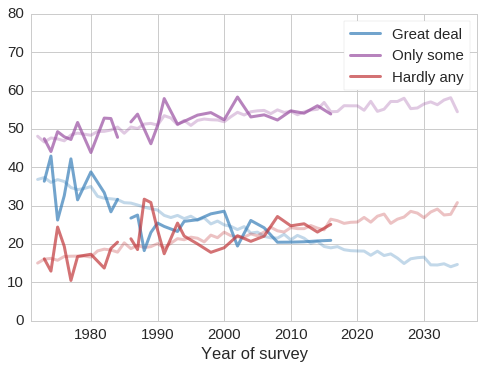

In [91]:
var = 'conclerg'
varnames = ['confident', 'someconf', 'noconf']
colors = [BLUE, PURPLE, RED]
train_year = 2016
years = np.arange(1972, 2036)
factors = ['ones', 'a', 'c']
index = varnames

pred = make_multi_pred(sample, var, varnames, train_year, years, factors, index)
plot_multi_pred(sample, pred, varnames, colors)
plot_conf(grouped_year)

thinkplot.config(xlim=[1971, 2038], ylim=[0, 80])

In [92]:
make_multi_pred(sample, var, varnames, train_year, [1976, 2016, 2036], factors, index)

,confident,someconf,noconf
1976,33.392039,49.066573,17.541388
2016,19.020782,54.596689,26.382529
2036,13.631560,56.886228,29.482212


## Bible

Which one of these statements comes closest to describing your feelings about the Bible? 

1. The Bible is the actual word of God and is to be taken literally, word for word

2. The Bible is the inspired word of God but not everything should be taken literally, word for word

3. The Bible is an ancient book of fables, legends, history and moral precepts recorded by man

In [93]:
def plot_bible(grouped):
    """Plot bible interpretation categories.
    
    grouped: GroupBy object
    """
    varnames = ['word', 'inspired', 'legends']
    colors = [BLUE, PURPLE, RED]
    labels = ['Literal', 'Inspired', 'Legends']
    series_seq = make_series_seq(grouped, varnames)
    plot_series_seq(series_seq, colors, labels)

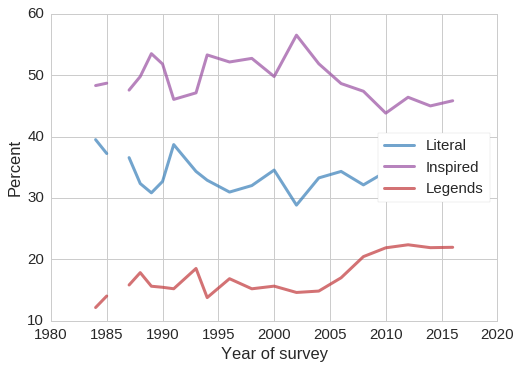

In [94]:
plot_bible(grouped_year)
thinkplot.config(xlabel='Year of survey', ylabel='Percent', loc='center right')

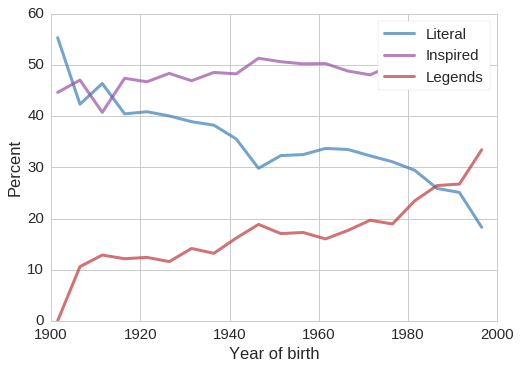

In [95]:
plot_bible(grouped_cohort)
thinkplot.config(xlabel='Year of birth', ylabel='Percent', loc='upper right')

In [96]:
make_model(sample, 'word').summary()

Optimization terminated successfully.
         Current function value: 0.632854
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   word   No. Observations:                32917
Model:                          Logit   Df Residuals:                    32911
Method:                           MLE   Df Model:                            5
Date:                Thu, 01 Jun 2017   Pseudo R-squ.:                0.004881
Time:                        10:04:39   Log-Likelihood:                -20832.
converged:                       True   LL-Null:                       -20934.
                                        LLR p-value:                 3.290e-42
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.7224      0.023    -31.813      0.000      -0.767      -0.678
c              0.0028      0.004      0.782      0.434      -0.004       0.010
c2             0.0003      0.000      2.258      0.024    4.19e-05       0.001
a              0.0121      0.004      3.242      0.001       0.005       0.019
a2             0.0003      0.000      1.844      0.065   -1.83e-05       0.001
ac             0.0006      0.000      2.162      0.031    5.79e-05       0.001
==============================================================================
"""

In [97]:
make_model(sample, 'inspired').summary()

Optimization terminated successfully.
         Current function value: 0.691429
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               inspired   No. Observations:                32917
Model:                          Logit   Df Residuals:                    32911
Method:                           MLE   Df Model:                            5
Date:                Thu, 01 Jun 2017   Pseudo R-squ.:                0.002210
Time:                        10:04:39   Log-Likelihood:                -22760.
converged:                       True   LL-Null:                       -22810.
                                        LLR p-value:                 3.555e-20
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1567      0.021     -7.307      0.000      -0.199      -0.115
c             -0.0258      0.003     -7.576      0.000      -0.033      -0.019
c2            -0.0008      0.000     -6.044      0.000      -0.001      -0.001
a             -0.0260      0.004     -7.390      0.000      -0.033      -0.019
a2            -0.0006      0.000     -4.091      0.000      -0.001      -0.000
ac            -0.0014      0.000     -5.156      0.000      -0.002      -0.001
==============================================================================
"""

In [98]:
make_model(sample, 'legends').summary()

Optimization terminated successfully.
         Current function value: 0.462435
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                legends   No. Observations:                32917
Model:                          Logit   Df Residuals:                    32911
Method:                           MLE   Df Model:                            5
Date:                Thu, 01 Jun 2017   Pseudo R-squ.:                0.009844
Time:                        10:04:39   Log-Likelihood:                -15222.
converged:                       True   LL-Null:                       -15373.
                                        LLR p-value:                 2.688e-63
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.3184      0.027    -49.235      0.000      -1.371      -1.266
c              0.0368      0.004      8.462      0.000       0.028       0.045
c2             0.0008      0.000      4.501      0.000       0.000       0.001
a              0.0246      0.005      5.438      0.000       0.016       0.034
a2             0.0006      0.000      2.893      0.004       0.000       0.001
ac             0.0014      0.000      3.826      0.000       0.001       0.002
==============================================================================
"""

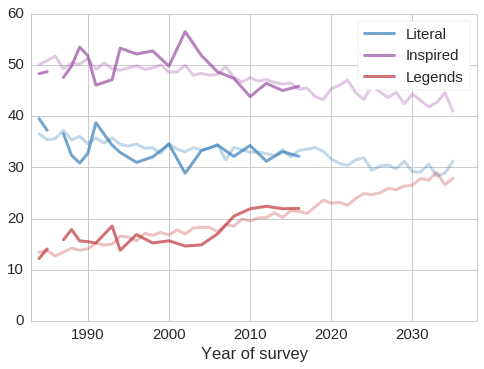

In [99]:
var = 'bible'
varnames = ['word', 'inspired', 'legends']
colors = [BLUE, PURPLE, RED]
train_year = 2016
years = np.arange(1984, 2036)
factors = ['ones', 'a', 'c']
index = varnames

pred = make_multi_pred(sample, var, varnames, train_year, years, factors, index)
plot_multi_pred(sample, pred, varnames, colors)
plot_bible(grouped_year)

thinkplot.config(xlim=[1983, 2038], ylim=[0, 60])

In [100]:
make_multi_pred(sample, var, varnames, train_year, [1986, 2016, 2036], factors, index)

,word,inspired,legends
1986,35.364565,51.285664,13.349771
2016,33.849947,44.487496,21.662557
2036,31.560409,41.669602,26.769989


## Resampling

In [101]:
import age_religion

gss = age_religion.read_gss()

In [102]:
def make_series_df(grouped, varnames):
    """Compute the percentage in each category.
    
    grouped: GroupBy object with one-hots for each category
    varnames: list of string column names
    
    returns: DataFrame
    """
    df = pd.DataFrame(columns=varnames)
    for var in varnames:
        df[var] = grouped[var].mean() * 100
    return df

In [103]:
def percentile_rows(series_seq, ps):
    """Computes percentiles from aligned series.
    
    series_seq: list of sequences
    ps: cumulative probabilities
    
    returns: Series of x-values, NumPy array with selected rows
    """
    df = pd.concat(series_seq, axis=1).dropna()
    xs = df.index
    array = df.values.transpose()
    array = np.sort(array, axis=0)
    nrows, ncols = array.shape
    indices = (ps * nrows).astype(int)
    rows = array[indices]
    return xs, rows

In [104]:
def plot_percentiles(dfs, varnames, colors, labels, plot=True, fill=True):
    """Plots 90% CI and median.
    
    dfs: list of DataFrames
    varnames: list of string variable names
    colors: list of string colors
    labels: list of string labels
    plot: boolean, whether to plot the median
    fill: boolean, whether to plot the CI
    """
    ps = np.array([0.05, 0.5, 0.95])

    for var, color, label in zip(varnames, colors, labels):
        series_seq = [df[var] for df in dfs]
        xs, rows = percentile_rows(series_seq, ps)
        if fill:
            thinkplot.fill_between(xs, rows[0], rows[2], color=color, alpha=0.2)
        if plot:
            thinkplot.plot(xs, rows[1], color=color, label=label)

In [105]:
def run_data(df, groupvar, varnames, iters=101):
    """Resample and extract data.
    
    df: DataFrame
    groupvar: string variable to group by
    varnames: list of string variable names
    iters: number of resamples
    """
    def run():
        sample = utils.ResampleByYear(df)
        grouped_year = sample.groupby([groupvar])
        return make_series_df(grouped_year, varnames)

    dfs = [run() for _ in range(iters)]
    return dfs

In [106]:
def run_model(df, var, varnames, train_year, years, index, iters=101):
    """Resample and make predictions.
    
    df: DataFrame
    var: string variable name to model
    varnames: list of string variable names
    train_year: last year of data to use
    years: list of years to predict
    index: list of string variable names to extract
    iters: number of resamples
    """
    factors = ['ones', 'a', 'c']

    def run():
        sample = utils.ResampleByYear(df)
        return make_multi_pred(sample, var, varnames,
                               train_year, years, factors, index)

    dfs = [run() for _ in range(iters)]
    return dfs

## Affiliation

In [155]:
groupvar = 'year'
varnames = ['prot', 'cath', 'none', 'other']
dfs1 = run_data(gss, groupvar, varnames, iters=101)

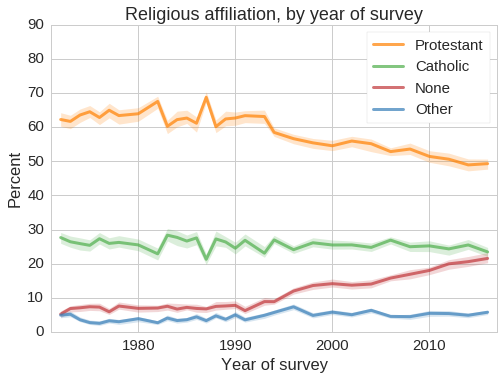

In [156]:
colors = [ORANGE, GREEN, RED, BLUE]
labels = ['Protestant', 'Catholic', 'None', 'Other']
plot_percentiles(dfs1, varnames, colors, labels)
thinkplot.config(title='Religious affiliation, by year of survey', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1971, 2017], ylim=[0, 90])

In [157]:
groupvar = 'cohort5'
dfs2 = run_data(gss, groupvar, varnames, iters=101)

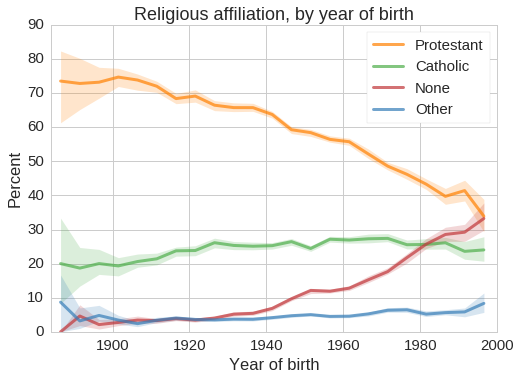

In [158]:
colors = [ORANGE, GREEN, RED, BLUE]
labels = ['Protestant', 'Catholic', 'None', 'Other']
plot_percentiles(dfs2, varnames, colors, labels)
thinkplot.config(title='Religious affiliation, by year of birth', 
                 xlabel='Year of birth', ylabel='Percent',
                 xlim=[1884, 2000], yim=[0, 90])

Train with all data

In [162]:
var = 'relig4'
train_year = 2016
years = np.arange(1972, 2037)
factors = ['ones', 'a', 'c']
index = ['prot', 'cath', 'other', 'none']

dfs3 = run_model(gss, var, varnames, train_year, years, index, iters=101)

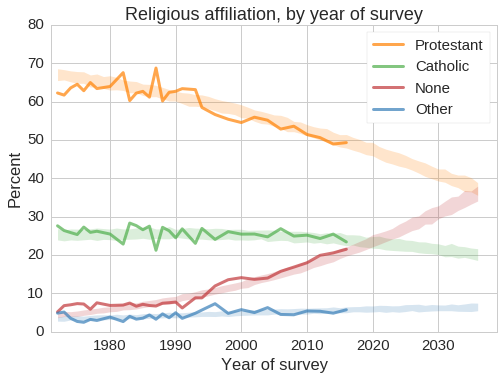

In [163]:
colors = [ORANGE, GREEN, RED, BLUE]
labels = ['Protestant', 'Catholic', 'None', 'Other']
nolabels= [None] * 4
plot_percentiles(dfs3, varnames, colors, nolabels, plot=False)
plot_percentiles(dfs1, varnames, colors, labels, fill=False)
thinkplot.config(title='Religious affiliation, by year of survey', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1971, 2039], ylim=[0, 80])

Train with data since 1990

In [164]:
var = 'relig4'
train_year = 1990, 2016
years = np.arange(1972, 2037)
factors = ['ones', 'a', 'c']
index = ['prot', 'cath', 'other', 'none']

dfs3 = run_model(gss, var, varnames, train_year, years, index, iters=101)

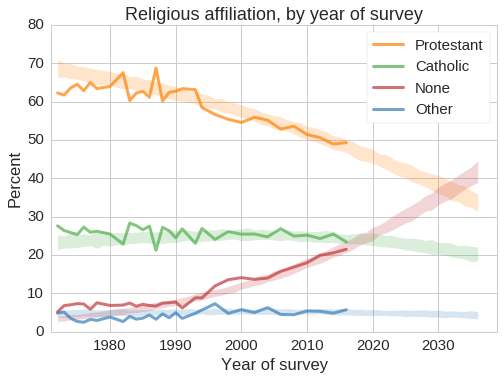

In [165]:
colors = [ORANGE, GREEN, RED, BLUE]
labels = ['Protestant', 'Catholic', 'None', 'Other']
nolabels= [None] * 4
plot_percentiles(dfs3, varnames, colors, nolabels, plot=False)
plot_percentiles(dfs1, varnames, colors, labels, fill=False)
thinkplot.config(title='Religious affiliation, by year of survey', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1971, 2039], ylim=[0, 80])

Train with data up to 2006

In [113]:
var = 'relig4'
train_year = 2006

dfs4 = run_model(gss, var, varnames, train_year, years, index, iters=101)

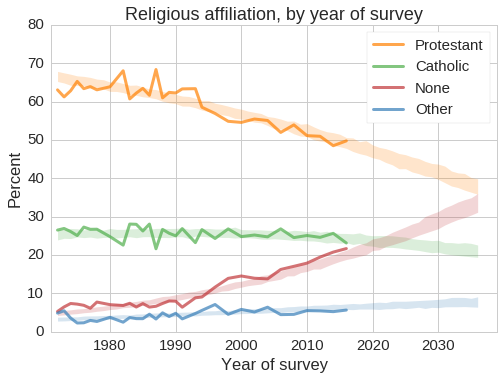

In [114]:
plot_percentiles(dfs4, varnames, colors, nolabels, plot=False)
plot_percentiles(dfs1, varnames, colors, labels, fill=False)
thinkplot.config(title='Religious affiliation, by year of survey', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1971, 2039], ylim=[0, 80])

Train with data up to 1996

In [115]:
train_year = 1996

dfs4 = run_model(gss, var, varnames, train_year, years, index, iters=101)

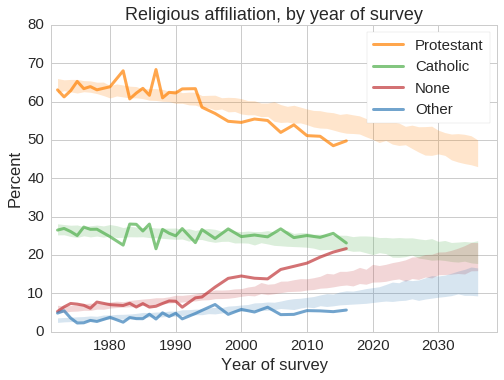

In [116]:
plot_percentiles(dfs4, varnames, colors, nolabels, plot=False)
plot_percentiles(dfs1, varnames, colors, labels, fill=False)
thinkplot.config(title='Religious affiliation, by year of survey', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1971, 2039], ylim=[0, 80])

In [117]:
ps = np.array([0.5])
series_seq = [df['other'] for df in dfs3]
xs, rows = percentile_rows(series_seq, ps)
series = pd.DataFrame(rows[0], index=xs)
series.loc[[1976, 1986, 1996, 2006, 2016]]

,0
1976,3.628038
1986,4.156393
1996,4.719972
2006,5.318774
2016,5.741458


## Beliefs

In [118]:
groupvar = 'year'
varnames = ['strongbelief', 'belief', 'nobelief']

In [119]:
dfs5 = run_data(gss, groupvar, varnames, iters=101)

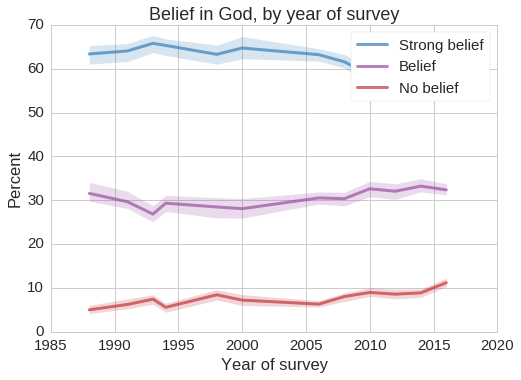

In [120]:
colors = [BLUE, PURPLE, RED]
labels = ['Strong belief', 'Belief', 'No belief']

plot_percentiles(dfs5, varnames, colors, labels)
thinkplot.config(title='Belief in God, by year of survey', 
                 xlabel='Year of survey', ylabel='Percent')

In [121]:
groupvar = 'cohort5'
dfs6 = run_data(gss, groupvar, varnames, iters=101)

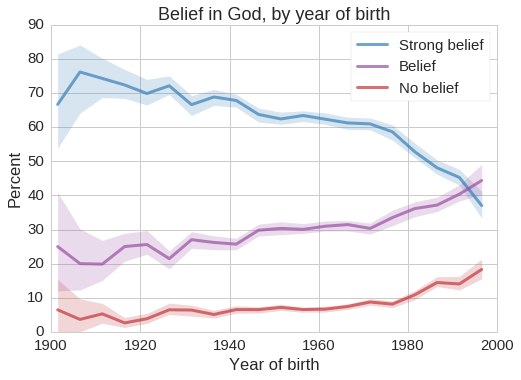

In [122]:
plot_percentiles(dfs6, varnames, colors, labels)
thinkplot.config(title='Belief in God, by year of birth', 
                 xlabel='Year of birth', ylabel='Percent',
                xlim=[1900, 2000], ylim=[0, 90])

In [123]:
var = 'belief3'
train_year = 2016
years = np.arange(1988, 2037)
factors = ['ones', 'a', 'c']
index = ['nobelief', 'belief', 'strongbelief']

In [124]:
dfs7 = run_model(gss, var, varnames, train_year, years, index, iters=101)

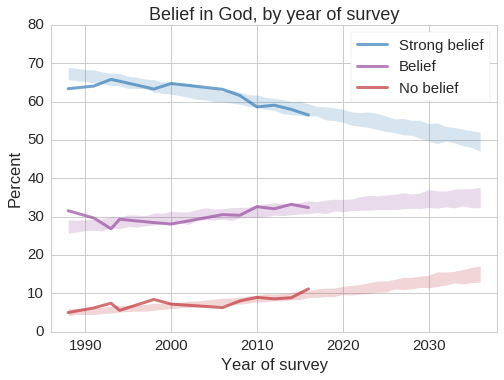

In [125]:
plot_percentiles(dfs7, varnames, colors, nolabels, plot=False)
plot_percentiles(dfs5, varnames, colors, labels, fill=False)
thinkplot.config(title='Belief in God, by year of survey', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1986, 2038], ylim=[0, 80])

In [126]:
var = 'nobelief'
ps = np.array([0.5])
series_seq = [df[var] for df in dfs7]
xs, rows = percentile_rows(series_seq, ps)
series = pd.DataFrame(rows[0], index=xs)
series.loc[[1976, 1986, 1996, 2006, 2016, 2026, 2036]]

,0
1976,NaN
1986,NaN
1996,6.093695
2006,7.890102
2016,9.756957
2026,12.363508
2036,15.251849


## Confidence

In [146]:
groupvar = 'year'
varnames = ['confident', 'someconf', 'noconf']

In [128]:
dfs8 = run_data(gss, groupvar, varnames, iters=101)

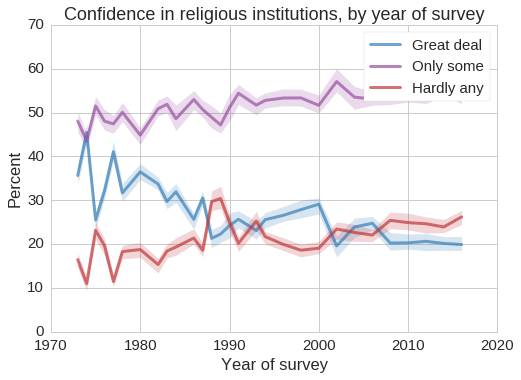

In [150]:
colors = [BLUE, PURPLE, RED]
labels = ['Great deal', 'Only some', 'Hardly any']

plot_percentiles(dfs8, varnames, colors, labels)
thinkplot.config(title='Confidence in religious institutions, by year of survey', 
                 xlabel='Year of survey', ylabel='Percent')

In [130]:
groupvar = 'cohort5'
dfs9 = run_data(gss, groupvar, varnames, iters=101)

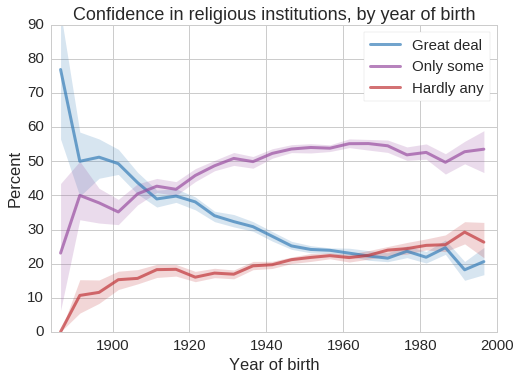

In [149]:
plot_percentiles(dfs9, varnames, colors, labels)
thinkplot.config(title='Confidence in religious institutions, by year of birth', 
                 xlabel='Year of birth', ylabel='Percent',
                xlim=[1884, 2000], ylim=[0, 90])

In [132]:
var = 'conclerg'
train_year = 2016
years = np.arange(1972, 2037)
factors = ['ones', 'a', 'c']
index = ['confident', 'someconf', 'noconf']

In [133]:
dfs10 = run_model(gss, var, varnames, train_year, years, index, iters=101)

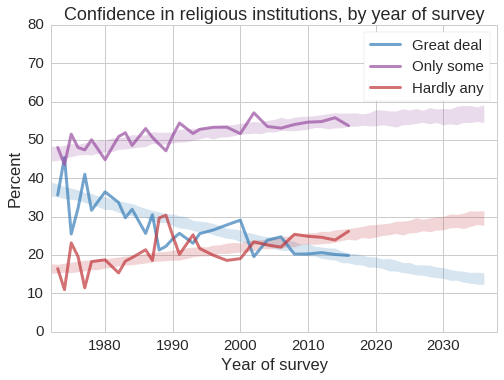

In [151]:
plot_percentiles(dfs10, varnames, colors, nolabels, plot=False)
plot_percentiles(dfs8, varnames, colors, labels, fill=False)
thinkplot.config(title='Confidence in religious institutions, by year of survey', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1972, 2038], ylim=[0, 80])

In [135]:
var = 'noconf'
ps = np.array([0.5])
series_seq = [df[var] for df in dfs10]
xs, rows = percentile_rows(series_seq, ps)
series = pd.DataFrame(rows[0], index=xs)
series.loc[[1976, 1986, 1996, 2006, 2016, 2026, 2036]]

,0
1976,17.013033
1986,19.020782
1996,21.275097
2006,23.388517
2016,25.466714
2026,27.580134
2036,29.552659


## Bible

In [136]:
groupvar = 'year'
varnames = ['inspired', 'literal', 'legends']

In [137]:
dfs11 = run_data(gss, groupvar, varnames, iters=101)

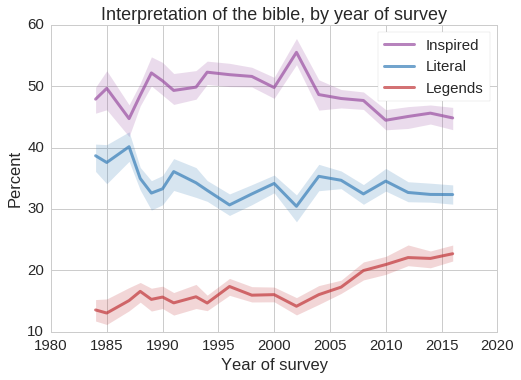

In [138]:
colors = [PURPLE, BLUE, RED]
labels = ['Inspired', 'Literal', 'Legends']

plot_percentiles(dfs11, varnames, colors, labels)
thinkplot.config(title='Interpretation of the bible, by year of survey', 
                 xlabel='Year of survey', ylabel='Percent')

In [139]:
groupvar = 'cohort5'
dfs12 = run_data(gss, groupvar, varnames, iters=101)

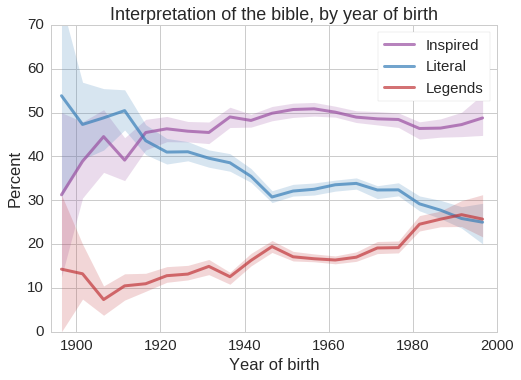

In [140]:
plot_percentiles(dfs12, varnames, colors, labels)
thinkplot.config(title='Interpretation of the bible, by year of birth', 
                 xlabel='Year of birth', ylabel='Percent',
                xlim=[1894, 2000], ylim=[0, 70])

In [141]:
var = 'bible'
train_year = 2016
years = np.arange(1984, 2037)
factors = ['ones', 'a', 'c']
index = ['literal', 'inspired', 'legends']

In [142]:
dfs13 = run_model(gss, var, varnames, train_year, years, index, iters=101)

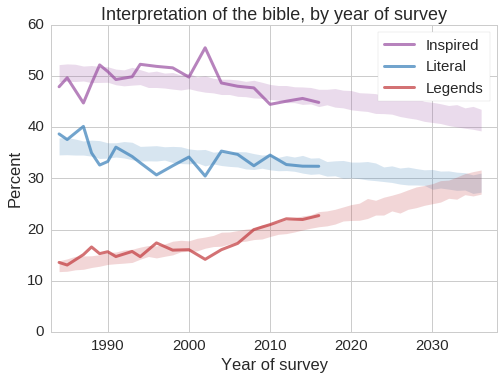

In [143]:
plot_percentiles(dfs13, varnames, colors, nolabels, plot=False)
plot_percentiles(dfs11, varnames, colors, labels, fill=False)
thinkplot.config(title='Interpretation of the bible, by year of survey', 
                 xlabel='Year of survey', ylabel='Percent',
                 xlim=[1983, 2038], ylim=[0, 60])

In [144]:
var = 'legends'
ps = np.array([0.5])
series_seq = [df[var] for df in dfs13]
xs, rows = percentile_rows(series_seq, ps)
series = pd.DataFrame(rows[0], index=xs)
series.loc[[1976, 1986, 1996, 2006, 2016, 2026, 2036]]

,0
1976,NaN
1986,13.420218
1996,15.815428
2006,18.633322
2016,22.050018
2026,25.431490
2036,29.270870
